# Vision por computadora 2

Alumnos:

- Julian Ferreira
- Amilcar Rincon Charris
- Paola Cartala

Configuración e Importación de Librerías

In [1]:
import os
import shutil
import random
import yaml
import math
from collections import Counter

import cv2
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import albumentations as A

c:\Users\julia\anaconda3\envs\VPC_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_dir = 'dataset'

if os.path.exists(os.path.join(dataset_dir, 'data.yaml')):
    print(f"El dataset ya se encuentra en la carpeta '{dataset_dir}'. Saltando descarga.")
    path = dataset_dir
else:
    print(f"Dataset no encontrado en '{dataset_dir}'. Procediendo a la descarga...")
    
    download_path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")
    shutil.copytree(download_path, dataset_dir, dirs_exist_ok=True)
    print(f"Dataset descargado en: '{dataset_dir}'")
    path = dataset_dir

El dataset ya se encuentra en la carpeta 'dataset'. Saltando descarga.


In [3]:
base_dir = path
train_images_dir = os.path.join(base_dir, 'train/images')
train_labels_dir = os.path.join(base_dir, 'train/labels')
valid_images_dir = os.path.join(base_dir, 'valid/images')
valid_labels_dir = os.path.join(base_dir, 'valid/labels')

with open(os.path.join(base_dir, 'data.yaml'), 'r') as file:
    data_yaml = yaml.safe_load(file)
    class_names = data_yaml['names']
    print("Clases del dataset:", class_names)

Clases del dataset: ['0', '1', '2', '3', '4']


## Primera entrega: EDA

### 1. Visualización de Muestras del Dataset

In [4]:
def visualize_image_with_bboxes(image_dir, label_dir, image_name, class_names):
    """
    Muestra una imagen con sus bounding boxes.
    """
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(f"Visualización de: {image_name}")

    # bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width_norm, height_norm = map(float, line.split())
                
                # desnormalizar coordenadas
                box_w = width_norm * w
                box_h = height_norm * h
                x_min = (x_center * w) - (box_w / 2)
                y_min = (y_center * h) - (box_h / 2)

                # rectangulo
                rect = patches.Rectangle((x_min, y_min), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                
                # etiqueta de clase
                class_name = class_names[int(class_id)]
                plt.text(x_min, y_min, class_name, color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.show()

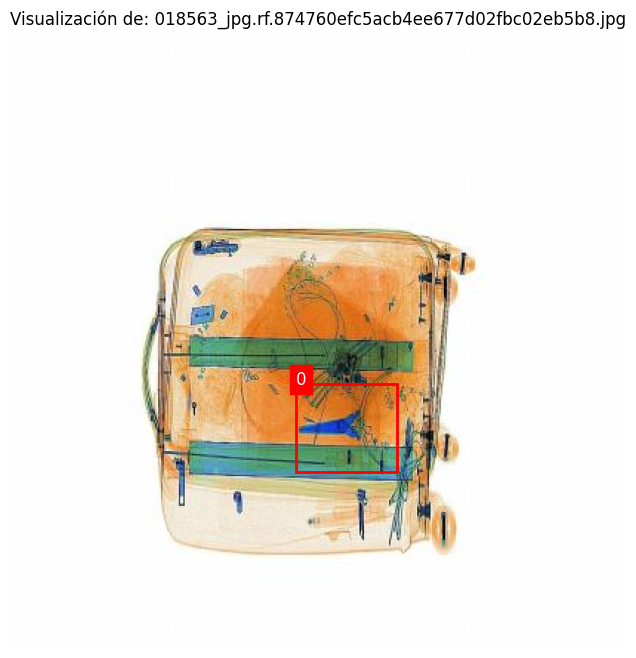

In [5]:
image_files = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
random_image = random.choice(image_files)
visualize_image_with_bboxes(train_images_dir, train_labels_dir, random_image, class_names)

### 2. Análisis de Bounding Boxes

In [6]:
def get_all_bboxes(label_dir):
    """
    Recorre todos los archivos de etiquetas y extrae la información de las bounding boxes.
    """
    bboxes = []
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    parts = list(map(float, line.split()))
                    bboxes.append(parts)
    return np.array(bboxes)

In [7]:
all_train_bboxes = get_all_bboxes(train_labels_dir)
print(f"Total de Bounding Boxes en el set de entrenamiento: {len(all_train_bboxes)}")

classes = all_train_bboxes[:, 0].astype(int)
centers_x = all_train_bboxes[:, 1]
centers_y = all_train_bboxes[:, 2]
widths = all_train_bboxes[:, 3]
heights = all_train_bboxes[:, 4]

Total de Bounding Boxes en el set de entrenamiento: 6181


#### 2.1. Distribución de Tamaños (Área)

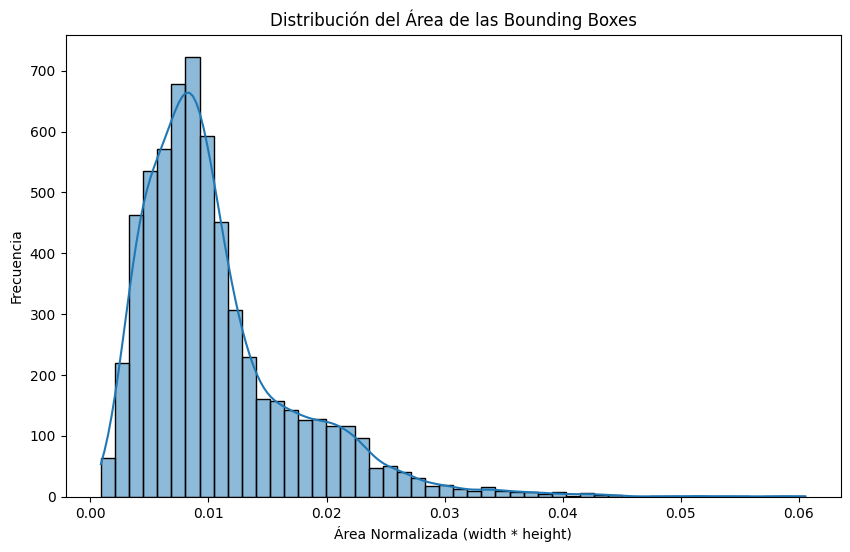

In [8]:
areas = widths * heights
plt.figure(figsize=(10, 6))
sns.histplot(areas, bins=50, kde=True)
plt.title('Distribución del Área de las Bounding Boxes')
plt.xlabel('Área Normalizada (width * height)')
plt.ylabel('Frecuencia')
plt.show()

Lo primero que salta a la vista es que casi todos los objetos que tenemos que encontrar son bastante chicos. Si vemos el gráfico, la mayoría de las cajitas tienen un área bastante pequeña, menos de 0.2. Hay algunos objetos grandes, pero son pocos.

#### 2.2. Distribución de Aspect Ratios

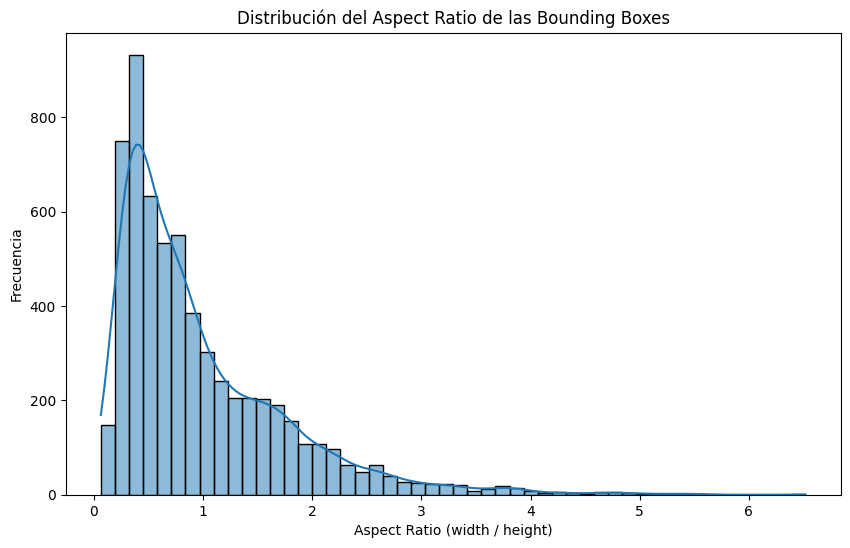

In [9]:
aspect_ratios = widths / heights
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=50, kde=True)
plt.title('Distribución del Aspect Ratio de las Bounding Boxes')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frecuencia')
plt.show()

Acá se ve que los objetos no tienen una única forma. Hay un montón que son más o menos cuadrados (el pico en 1.0), pero también hay bastantes que son más altos que anchos, o más anchos que bajos.

#### 2.3. Mapa de Calor de Ubicaciones

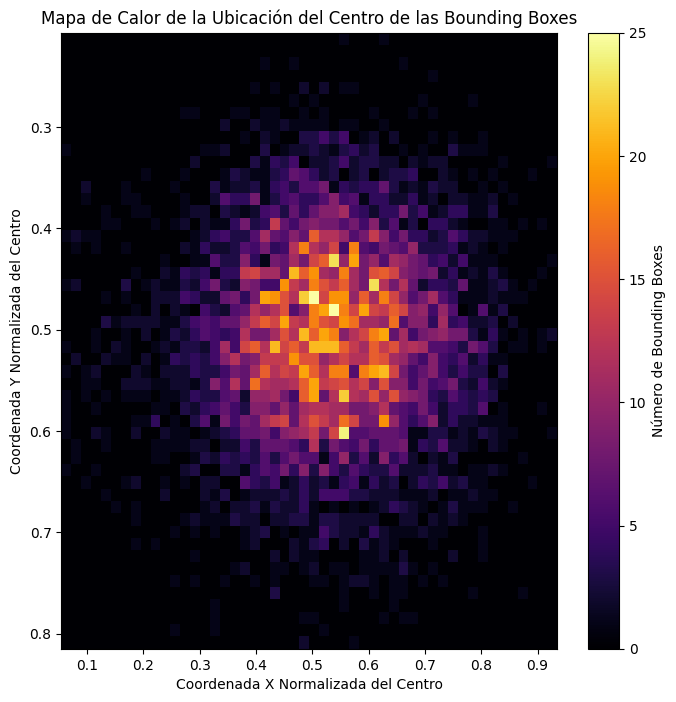

In [10]:
plt.figure(figsize=(8, 8))
plt.hist2d(centers_x, centers_y, bins=50, cmap='inferno')
plt.colorbar(label='Número de Bounding Boxes')
plt.title('Mapa de Calor de la Ubicación del Centro de las Bounding Boxes')
plt.xlabel('Coordenada X Normalizada del Centro')
plt.ylabel('Coordenada Y Normalizada del Centro')
plt.gca().invert_yaxis()

Este gráfico es el más claro de todos. Casi todos los objetos aparecen en el centro de la imagen. A medida que te vas a los bordes, no hay casi nada. Tiene lógica, porque las cosas pasan por el medio del escáner.

### 3. Data Augmentation para Balanceo de Clases

In [11]:
def plot_class_distribution(label_dirs, title, class_names_map):
    """
    Calcula y grafica la distribución de clases a partir de directorios de etiquetas.
    """
    all_classes = []
    if not isinstance(label_dirs, list):
        label_dirs = [label_dirs]
        
    for label_dir in label_dirs:
        if not os.path.isdir(label_dir):
            print(f"Advertencia: El directorio {label_dir} no existe. Será omitido.")
            continue
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                with open(os.path.join(label_dir, label_file), 'r') as f:
                    for line in f:
                        class_id = int(float(line.split()[0]))
                        all_classes.append(class_id)
    
    # ocurrencias de cada clase
    class_counts = Counter(all_classes)
    
    class_indices = sorted(class_counts.keys())
    counts = [class_counts[i] for i in class_indices]
    class_labels = [class_names_map[i] for i in class_indices]

    plt.figure(figsize=(12, 7))
    sns.barplot(x=class_labels, y=counts, hue=class_labels, palette='viridis', legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Clase', fontsize=12)
    plt.ylabel('Número de Instancias', fontsize=12)
    plt.xticks(rotation=45)
    
    for index, value in enumerate(counts):
        plt.text(index, value + 0.5, str(value), ha='center')
        
    plt.tight_layout()
    plt.show()

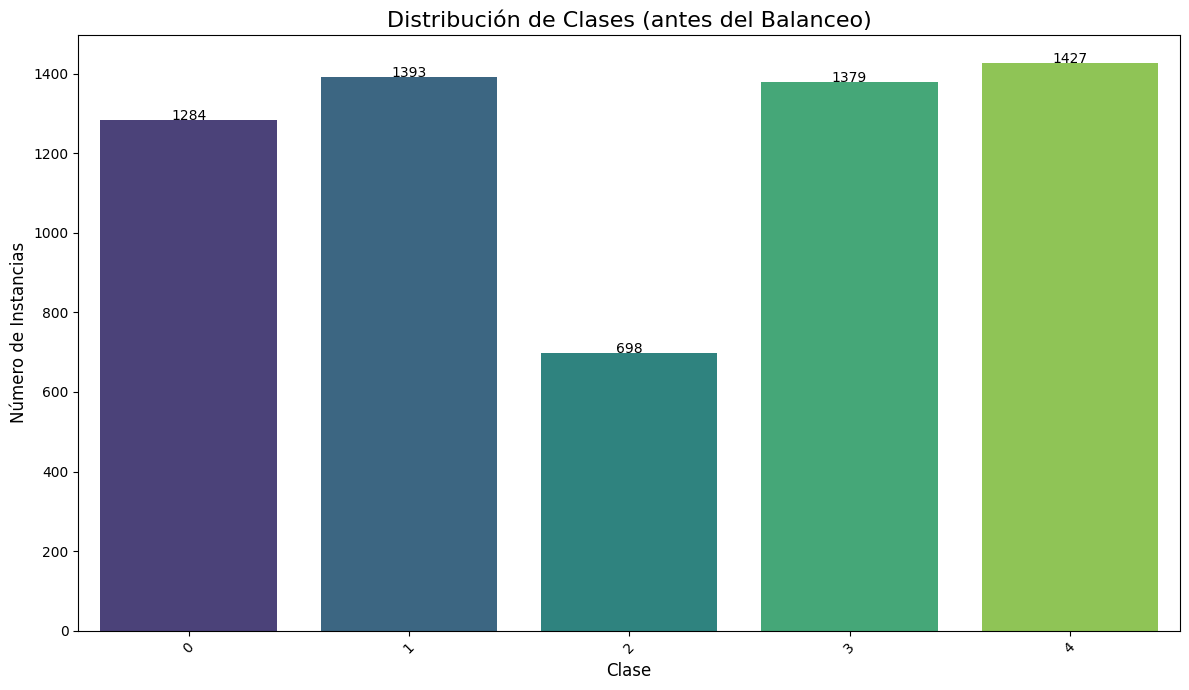

In [12]:
plot_class_distribution([train_labels_dir], 'Distribución de Clases (antes del Balanceo)', class_names)

#### 3.1 Calcular la distribución inicial y definir el objetivo

In [13]:
initial_class_counts = Counter()
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(float(line.split()[0]))
                    initial_class_counts[class_id] += 1

other_class_counts = [count for class_id, count in initial_class_counts.items() if class_id != 2]
target_count = int(np.mean(other_class_counts)) if other_class_counts else 0

initial_count_class_2 = initial_class_counts.get(2, 0)

print(f"Distribución inicial: {sorted(initial_class_counts.items())}")
print(f"Instancias iniciales de la clase '2': {initial_count_class_2}")
print(f"Objetivo de instancias (promedio de las otras clases): {target_count}")

Distribución inicial: [(0, 1284), (1, 1393), (2, 698), (3, 1379), (4, 1427)]
Instancias iniciales de la clase '2': 698
Objetivo de instancias (promedio de las otras clases): 1370


In [14]:
aug_images_dir = os.path.join(os.path.dirname(train_images_dir), 'augmented_images')
aug_labels_dir = os.path.join(os.path.dirname(train_labels_dir), 'augmented_labels')

if os.path.exists(aug_images_dir):
    shutil.rmtree(aug_images_dir)
if os.path.exists(aug_labels_dir):
    shutil.rmtree(aug_labels_dir)
os.makedirs(aug_images_dir, exist_ok=True)
os.makedirs(aug_labels_dir, exist_ok=True)

print(f"\nDirectorios de aumentación limpios en: {aug_images_dir}")


Directorios de aumentación limpios en: dataset\train\augmented_images


In [15]:
class_2_images = []
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip() and line.startswith('2 '):
                    class_2_images.append(label_file.replace('.txt', '.jpg'))
                    break

print(f"Se encontraron {len(class_2_images)} imágenes con la clase '2'.")

Se encontraron 698 imágenes con la clase '2'.


In [16]:
if initial_count_class_2 > 0 and initial_count_class_2 < target_count:
    num_augmentations = math.ceil((target_count / initial_count_class_2) - 1)
    num_augmentations = max(1, num_augmentations)
else:
    num_augmentations = 0

print(f"Se generarán {num_augmentations} aumentos por cada imagen de la clase '2'.")

Se generarán 1 aumentos por cada imagen de la clase '2'.


#### 3.2. Definir la pipeline de aumentación

In [17]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=25, p=0.6, border_mode=cv2.BORDER_CONSTANT),
    A.Blur(blur_limit=3, p=0.2),
    A.GaussNoise(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

#### 3.3. Función para generar y guardar imágenes aumentadas

In [18]:
def augment_and_save(image_path, label_path, output_img_dir, output_lbl_dir, transform, num_augmentations):
    """
    Aplica transformaciones a una imagen y su etiqueta, y guarda los resultados.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.split())
            bboxes.append([x, y, w, h])
            class_labels.append(int(class_id))
    
    for i in range(num_augmentations):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        new_img_name = f"{base_name}_aug_{i}.jpg"
        new_lbl_name = f"{base_name}_aug_{i}.txt"
        
        aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(output_img_dir, new_img_name), aug_image_bgr)
        
        with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
            for bbox, class_id in zip(aug_bboxes, augmented['class_labels']):
                x, y, w, h = bbox
                f.write(f"{class_id} {x} {y} {w} {h}\n")

#### 3.4. Aplicar aumentación

In [19]:
if num_augmentations > 0:
    for image_name in class_2_images:
        img_path = os.path.join(train_images_dir, image_name)
        lbl_path = os.path.join(train_labels_dir, image_name.replace('.jpg', '.txt'))
        
        if os.path.exists(img_path):
            augment_and_save(img_path, lbl_path, aug_images_dir, aug_labels_dir, transform, num_augmentations)

    print("\n¡Proceso de aumentación de datos para la clase '2' completado!")
else:
    print("\nNo fue necesario realizar aumentación de datos para la clase '2'.")


¡Proceso de aumentación de datos para la clase '2' completado!


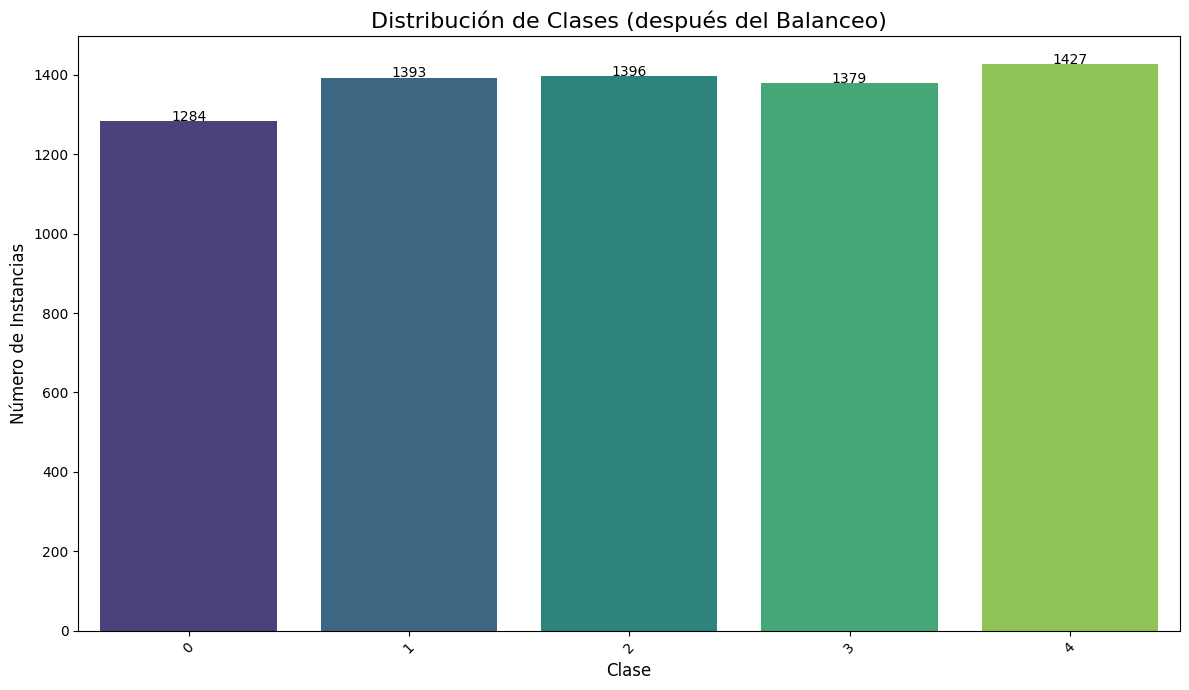

In [20]:
plot_class_distribution([train_labels_dir, aug_labels_dir], 'Distribución de Clases (después del Balanceo)', class_names)

## Segunda entrega: baseline y conclusiones preliminares

### 1. Implementacion Faster R-CNN

In [5]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
torch.cuda.empty_cache()


In [6]:
model = fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 5 + 1

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


c:\Users\julia\anaconda3\envs\VPC_2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\julia\anaconda3\envs\VPC_2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
transform = T.Compose([
    T.ToTensor()
])

In [8]:
class XRayBaggageAnomalyDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, labels_dir, transforms = None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.img_files = sorted(os.listdir(images_dir))
        self.label_files = sorted(os.listdir(labels_dir))


    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.img_files[index])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        label_path = os.path.join(self.labels_dir, self.label_files[index])

        boxes = []
        labels = []

        with open(label_path, 'r') as f:
            for line in f:

                class_id, x_center, y_center, width_norm, height_norm = map(float, line.split())

                box_w = width_norm * w
                box_h = height_norm * h

                x_min = (x_center * w) - (box_w / 2)
                y_min = (y_center * h) - (box_h / 2)
                x_max = x_min + box_w
                y_max = y_min + box_h

                boxes.append([x_min, y_min, x_max, y_max])
                # El 0 está reservado para el fondo en el modelo
                labels.append(int(class_id) + 1)

        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.tensor([index])

        
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target
    
    def __len__(self):
        return len(self.img_files)



In [9]:
train_dataset = XRayBaggageAnomalyDataset(
    images_dir = train_images_dir,
    labels_dir = train_labels_dir,
    transforms = transform
)

valid_dataset = XRayBaggageAnomalyDataset(
    images_dir = valid_images_dir,
    labels_dir = valid_labels_dir,
    transforms = transform
)

In [ ]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, 
                                   collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False, 
                                    collate_fn=lambda x: tuple(zip(*x)))

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Ejecutandose en: {device}")

Ejecutandose en: cuda


In [12]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
#Se puede cambair a ADAM
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, 
                                                   weight_decay=0.0005)


In [14]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [15]:
def train(model, epochs, lr, optimizer, train_loader, valid_loader):
    train_epoch_loss = []
    valid_epoch_loss = []
    mAP = []
    metric = MeanAveragePrecision().to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass
            losses.backward()
            optimizer.step()
            train_loss += losses.item()

        lr.step()
        avg_train_loss = train_loss / len(train_loader)
        train_epoch_loss.append(avg_train_loss)

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, targets in valid_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


                predictions = model(images)
                metric.update(predictions, targets)

                model.train()
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                valid_loss += losses.item()
                model.eval()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_epoch_loss.append(avg_valid_loss)
        mAP_results = metric.compute()
        mAP.append(mAP_results)
        metric.reset()


        print(f" Epoca: {epoch} | " \
          f"Train/Valid loss: {train_epoch_loss[-1]}/{valid_epoch_loss[-1]})" \
            f"Validation mAP@50: {mAP_results['map_50']:.4f} | mAP@75: {mAP_results['map_75']:.4f}")



In [16]:
train(
    model = model,
    epochs = 10,
    lr = lr_scheduler,
    optimizer = optimizer,
    train_loader = train_loader,
    valid_loader = valid_loader
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacity of 12.00 GiB of which 0 bytes is free. Of the allocated memory 23.64 GiB is allocated by PyTorch, and 662.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### 2. Testeo del modelo

In [144]:
torch.save(model.state_dict(), "fasterrcnn_model.pth")


In [145]:
model = fasterrcnn_resnet50_fpn(weights=None)

num_classes = 5 + 1

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

bestmodel = torch.load('fasterrcnn_model.pth')
model.load_state_dict(bestmodel)

model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [164]:
test_images_dir = os.path.join(base_dir, 'test/images')
test_labels_dir = os.path.join(base_dir, 'test/labels')


In [165]:
test_dataset = XRayBaggageAnomalyDataset(
    images_dir = test_images_dir,
    labels_dir = test_labels_dir,
    transforms = transform
)

In [166]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, 
                                    collate_fn=lambda x: tuple(zip(*x)))

In [167]:
data_iterator = iter(test_loader)

images, targets = next(data_iterator)

In [168]:
test_img = images[0]
test_target = targets[0]

test_img_indx = test_target['image_id']
test_img_path = sorted(os.listdir(test_images_dir))[test_img_indx]

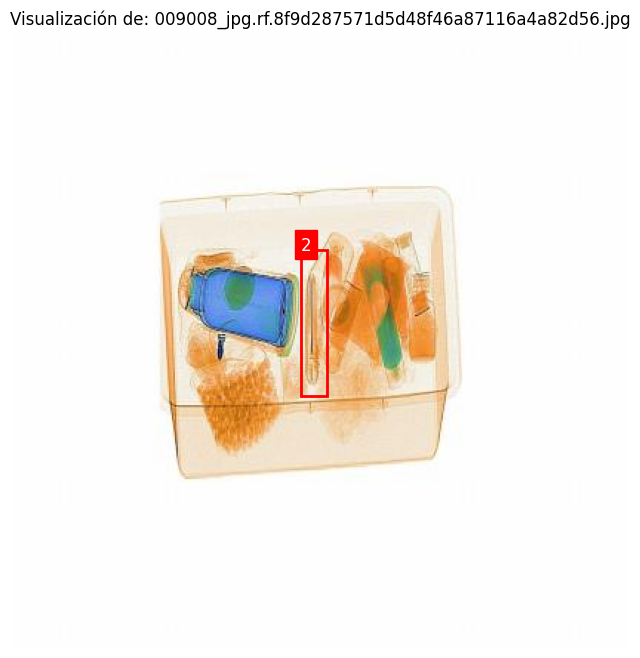

In [169]:
visualize_image_with_bboxes(test_images_dir, test_labels_dir, test_img_path, class_names)

In [170]:
test_img = test_img.to(device)
with torch.no_grad():
    predictions = model([test_img])

In [171]:
predicted_box = predictions[0]['boxes'].cpu().detach().numpy()
predicted_box = predicted_box[0]
predicted_class = predictions[0]['labels']


In [172]:
predicted_class = predictions[0]['labels'].cpu().detach().numpy()[0] - 1

In [173]:
x_min, y_min, x_max, y_max = predicted_box

In [174]:
def visualize_image_with_predicted_bboxes(image_dir, boxes, image_name, predicted_class):
    """
    Muestra una imagen con sus bounding boxes.
    """
    image_path = os.path.join(image_dir, image_name)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(f"Visualización de: {image_name}")
    x_min, y_min, x_max, y_max = boxes
    rect_width = x_max - x_min
    rect_height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), rect_width, rect_height, 
                             linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

    plt.text(x_min, y_min, predicted_class, color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.show()

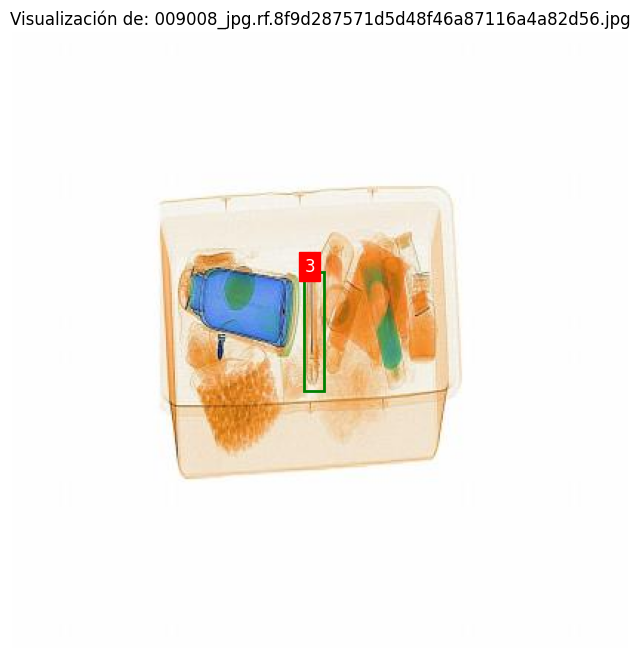

In [175]:
visualize_image_with_predicted_bboxes(test_images_dir, predicted_box, test_img_path, predicted_class)

In [177]:
#En la imagend de prueba se logra identificar correctamente el objeto pero se obtiene un error en la clase del mismo